Loading CIFAR-10...
Epoch 020/200 | tr_loss=1.2677 tr_acc=56.07% | te_loss=1.3053 te_acc=54.61% | time=3.6s
Epoch 040/200 | tr_loss=1.1622 tr_acc=59.70% | te_loss=1.2227 te_acc=57.49% | time=3.6s
Epoch 060/200 | tr_loss=1.0809 tr_acc=62.50% | te_loss=1.1634 te_acc=60.33% | time=3.7s
Epoch 080/200 | tr_loss=1.0207 tr_acc=64.67% | te_loss=1.1117 te_acc=61.71% | time=3.7s
Epoch 100/200 | tr_loss=0.9855 tr_acc=65.74% | te_loss=1.0935 te_acc=62.49% | time=3.7s
Epoch 120/200 | tr_loss=0.9513 tr_acc=67.24% | te_loss=1.0646 te_acc=63.22% | time=3.6s
Epoch 140/200 | tr_loss=0.9318 tr_acc=67.66% | te_loss=1.0571 te_acc=64.00% | time=3.7s
Epoch 160/200 | tr_loss=0.9157 tr_acc=68.36% | te_loss=1.0452 te_acc=64.47% | time=3.7s
Epoch 180/200 | tr_loss=0.9030 tr_acc=68.74% | te_loss=1.0372 te_acc=64.73% | time=3.7s
Epoch 200/200 | tr_loss=0.8981 tr_acc=68.97% | te_loss=1.0343 te_acc=64.76% | time=3.8s

Best test accuracy observed: 64.97%
Per-class accuracy:
  0 (airplane  ): 69.20%
  1 (automobile): 

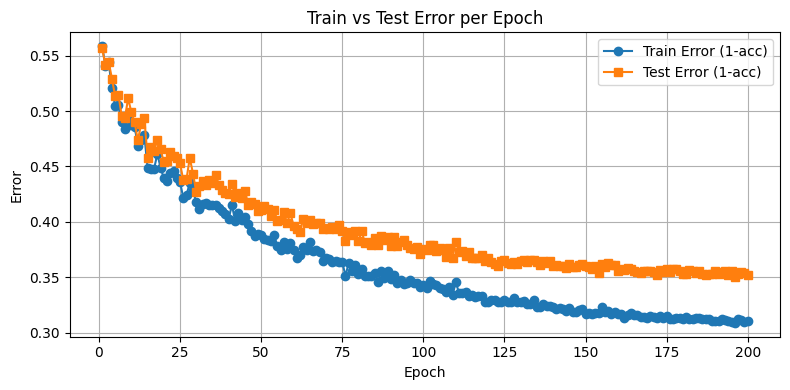

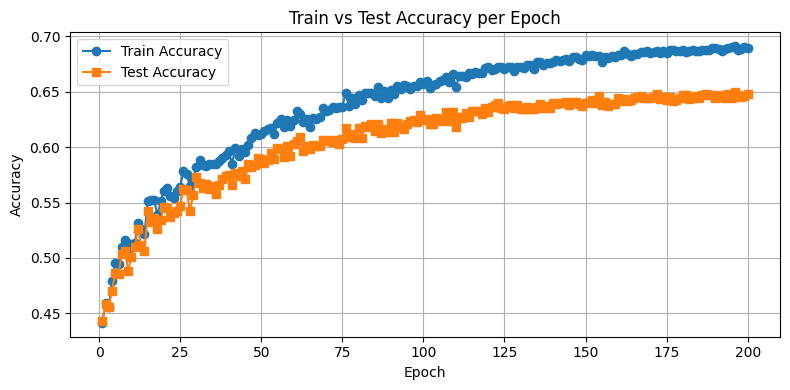

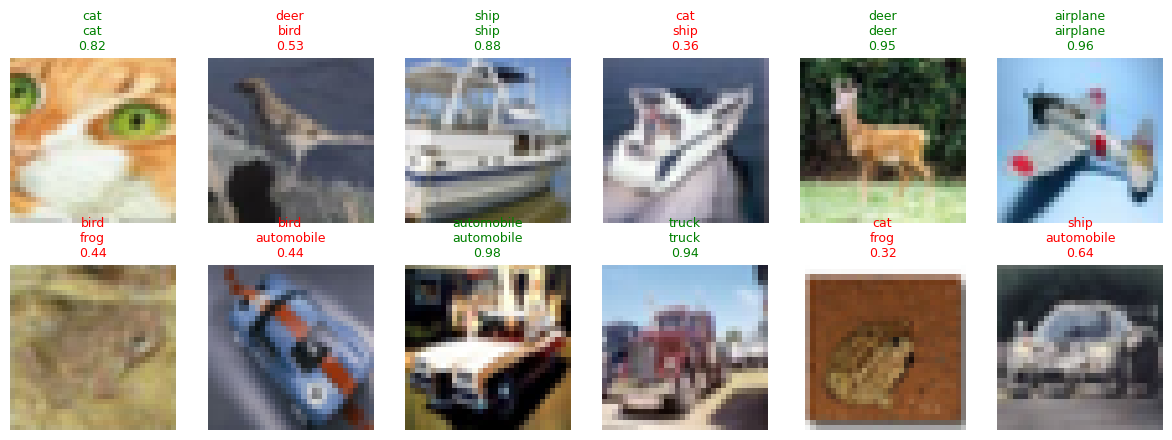

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import time
import math

DATA_DIR = "cifar-10-batches-py"

def load_cifar_batch(path):
    with open(path, "rb") as f:
        d = pickle.load(f, encoding="bytes")
    X = d[b"data"].astype(np.float32)    # shape (N, 3072)
    y = np.array(d[b"labels"], dtype=np.int64)
    return X, y

def load_cifar10(data_dir=DATA_DIR):
    Xs, ys = [], []
    for i in range(1, 6):
        Xb, yb = load_cifar_batch(os.path.join(data_dir, f"data_batch_{i}"))
        Xs.append(Xb); ys.append(yb)
    Xtr = np.vstack(Xs)
    ytr = np.hstack(ys)
    Xte, yte = load_cifar_batch(os.path.join(data_dir, "test_batch"))
    return Xtr, ytr, Xte, yte

def to_one_hot(y, C=10):
    oh = np.zeros((y.shape[0], C), dtype=np.float32)
    oh[np.arange(y.shape[0]), y] = 1.0
    return oh

def compute_channel_mean_std(X):
    X_img = X.reshape(-1, 3, 32, 32)
    mean = X_img.mean(axis=(0,2,3), keepdims=True)    # shape (1,3,1,1)
    std  = X_img.std(axis=(0,2,3), keepdims=True)
    return mean, std

def normalize(X, mean, std):
    X_img = X.reshape(-1, 3, 32, 32)
    Xn = (X_img - mean) / (std + 1e-8)
    return Xn.reshape(-1, 3072)

def random_crop_flip(batch_flat, pad=4, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    B = batch_flat.shape[0]
    imgs = batch_flat.reshape(B, 3, 32, 32)
    H = 32 + 2*pad; W = 32 + 2*pad
    padded = np.zeros((B, 3, H, W), dtype=imgs.dtype)
    padded[:, :, pad:pad+32, pad:pad+32] = imgs
    out = np.empty_like(imgs)
    for i in range(B):
        top = rng.integers(0, 2*pad+1)
        left = rng.integers(0, 2*pad+1)
        crop = padded[i, :, top:top+32, left:left+32]
        if rng.random() < 0.5:
            crop = crop[:, :, ::-1]
        out[i] = crop
    return out.reshape(B, -1)

def relu(x): return np.maximum(0.0, x)
def relu_deriv(x): return (x > 0).astype(np.float32)
def softmax(logits):
    z = logits - logits.max(axis=1, keepdims=True)
    e = np.exp(z)
    return e / e.sum(axis=1, keepdims=True)

def cross_entropy(probs, y_onehot):
    p = np.clip(probs, 1e-12, 1.0)
    return -np.sum(y_onehot * np.log(p)) / probs.shape[0]


class MLP:
    def __init__(self, layer_sizes, seed=0, init='xavier'):
        rng = np.random.default_rng(seed)
        self.sizes = layer_sizes
        self.W = []
        self.b = []
        for i in range(len(layer_sizes)-1):
            ni, no = layer_sizes[i], layer_sizes[i+1]
            if init == 'xavier':
                limit = math.sqrt(6.0 / (ni + no))
                W = rng.uniform(-limit, limit, (no, ni)).astype(np.float32)
            else:
                W = rng.standard_normal((no, ni)).astype(np.float32) * 0.01
            b = np.zeros((no,), dtype=np.float32)
            self.W.append(W); self.b.append(b)
        self.vW = [np.zeros_like(W) for W in self.W]
        self.vb = [np.zeros_like(b) for b in self.b]

    def forward(self, X):
        acts = [X]
        zs = []
        for i in range(len(self.W)):
            z = acts[-1] @ self.W[i].T + self.b[i]
            zs.append(z)
            a = relu(z) if i < len(self.W)-1 else softmax(z)
            acts.append(a)
        return zs, acts

    def predict(self, X):
        _, acts = self.forward(X.astype(np.float32))
        return acts[-1].argmax(axis=1)

    def train_minibatch(self, Xb, Yb, lr, momentum=0.9, weight_decay=0.0):
        B = Xb.shape[0]
        zs, acts = self.forward(Xb)
        probs = acts[-1]
        loss = cross_entropy(probs, Yb)
        if weight_decay:
            for W in self.W:
                loss += 0.5 * weight_decay * np.sum(W*W)
        delta = (probs - Yb) / B
        dW = [None] * len(self.W)
        db = [None] * len(self.b)
        dW[-1] = delta.T @ acts[-2]
        db[-1] = delta.sum(axis=0)
        upstream = delta
        for l in range(len(self.W)-2, -1, -1):
            Wnext = self.W[l+1]
            z = zs[l]
            upstream = (upstream @ Wnext) * relu_deriv(z)
            dW[l] = upstream.T @ acts[l]
            db[l] = upstream.sum(axis=0)
        # weight decay
        if weight_decay:
            for i in range(len(dW)):
                dW[i] += weight_decay * self.W[i]
        # SGD with momentum update
        for i in range(len(self.W)):
            self.vW[i] = momentum * self.vW[i] - lr * dW[i]
            self.vb[i] = momentum * self.vb[i] - lr * db[i]
            self.W[i] += self.vW[i]
            self.b[i] += self.vb[i]
        return float(loss)

def iterate_minibatches(X, Y, batch_size, shuffle=True, seed=None):
    N = X.shape[0]
    idx = np.arange(N)
    if shuffle:
        rng = np.random.default_rng(seed)
        rng.shuffle(idx)
    for i in range(0, N, batch_size):
        j = idx[i:i+batch_size]
        yield X[j], Y[j]

def evaluate_loss_acc(model, X, Y_onehot, batch_size=4096):
    total_loss = 0.0
    total_correct = 0
    n = X.shape[0]
    for i in range(0, n, batch_size):
        Xb = X[i:i+batch_size]
        Yb = Y_onehot[i:i+batch_size]
        _, acts = model.forward(Xb)
        probs = acts[-1]
        total_loss += cross_entropy(probs, Yb) * Xb.shape[0]
        preds = probs.argmax(axis=1)
        total_correct += (preds == Yb.argmax(axis=1)).sum()
    return float(total_loss / n), float(total_correct / n)

def plot_error_vs_epoch(train_errors, test_errors, savepath=None):
    epochs = np.arange(1, len(train_errors)+1)
    plt.figure(figsize=(8,4))
    plt.plot(epochs, train_errors, 'o-', label='Train Error (1-acc)')
    plt.plot(epochs, test_errors, 's-', label='Test Error (1-acc)')
    plt.xlabel("Epoch"); plt.ylabel("Error")
    plt.title("Train vs Test Error per Epoch")
    plt.grid(True); plt.legend(); plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi=150)
    plt.show()

def plot_acc_vs_epoch(train_accs, test_accs, savepath=None):
    epochs = np.arange(1, len(train_accs)+1)
    plt.figure(figsize=(8,4))
    plt.plot(epochs, train_accs, 'o-', label='Train Accuracy')
    plt.plot(epochs, test_accs, 's-', label='Test Accuracy')
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.title("Train vs Test Accuracy per Epoch")
    plt.grid(True); plt.legend(); plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi=150)
    plt.show()

def show_prediction_grid(model, X_flat, y_true, mean, std, class_names, n=12, seed=1, savepath=None):
    rng = np.random.default_rng(seed)
    idxs = rng.choice(len(X_flat), size=n, replace=False)
    imgs = unnormalize_images(X_flat[idxs], mean, std)
    probs = []
    for i in range(0, n, 256):
        _, acts = model.forward(X_flat[idxs[i:i+256]])
        probs.append(acts[-1])
    probs = np.vstack(probs)
    preds = probs.argmax(axis=1); confs = probs.max(axis=1)
    cols = 6; rows = int(np.ceil(n/cols))
    plt.figure(figsize=(2*cols, 2.2*rows))
    for k, idx in enumerate(idxs, 1):
        plt.subplot(rows, cols, k)
        plt.imshow(imgs[k-1])
        true_lbl = class_names[int(y_true[idx])]
        pred_lbl = class_names[int(preds[k-1])]
        conf = float(confs[k-1])
        ok = (pred_lbl == true_lbl)
        plt.title(f"{pred_lbl}\n{true_lbl}\n{conf:.2f}", color=('green' if ok else 'red'), fontsize=9)
        plt.axis('off')
    plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi=150)
    plt.show()

def unnormalize_images(X_flat, mean, std):
    X_img = X_flat.reshape(-1, 3, 32, 32)
    imgs_01 = X_img * (std + 1e-8) + mean
    imgs_255 = np.clip(imgs_01 * 255.0, 0, 255).astype(np.uint8)
    return imgs_255.transpose(0, 2, 3, 1)

def main():
    LAYERS = [3072, 1024, 10]
    SEED = 2025
    NUM_EPOCHS = 200      
    BATCH_SIZE = 128
    LR = 0.01
    MOMENTUM = 0.9
    WEIGHT_DECAY = 1e-4
    LR_DECAY = 0.98
    PRINT_EVERY = 20       

    CLASS_NAMES = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

    print("Loading CIFAR-10...")
    Xtr, ytr, Xte, yte = load_cifar10(DATA_DIR)
    Xtr /= 255.0; Xte /= 255.0
    mean, std = compute_channel_mean_std(Xtr)
    Xtr = normalize(Xtr, mean, std)
    Xte = normalize(Xte, mean, std)
    ytr_oh = to_one_hot(ytr)
    yte_oh = to_one_hot(yte)

    rng = np.random.default_rng(SEED)
    model = MLP(LAYERS, seed=SEED)

    train_losses = []; test_losses = []
    train_accs = []; test_accs = []
    best_test_acc = -1.0
    best_state = None

    for ep in range(1, NUM_EPOCHS+1):
        t0 = time.time()
        losses = []
        idxs = rng.permutation(Xtr.shape[0])

        for start in range(0, Xtr.shape[0], BATCH_SIZE):
            end = start + BATCH_SIZE
            batch_idx = idxs[start:end]
            Xb_raw = Xtr[batch_idx]
            Yb_onehot = ytr_oh[batch_idx]

            Xb = random_crop_flip(Xb_raw, pad=4, rng=rng)
            loss = model.train_minibatch(Xb, Yb_onehot, LR, MOMENTUM, WEIGHT_DECAY)

            losses.append(loss * Xb.shape[0])


        mean_train_loss = float(np.sum(losses) / Xtr.shape[0])


        train_loss, train_acc = evaluate_loss_acc(model, Xtr, ytr_oh, batch_size=4096)
        test_loss, test_acc = evaluate_loss_acc(model, Xte, yte_oh, batch_size=4096)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)


        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_state = {"W":[W.copy() for W in model.W], "b":[b.copy() for b in model.b]}

        if ep % PRINT_EVERY == 0:
            print(f"Epoch {ep:03d}/{NUM_EPOCHS} | tr_loss={train_loss:.4f} tr_acc={train_acc*100:.2f}% "
                  f"| te_loss={test_loss:.4f} te_acc={test_acc*100:.2f}% | time={time.time()-t0:.1f}s")

        LR *= LR_DECAY


    if best_state is not None:
        model.W = [w.copy() for w in best_state["W"]]
        model.b = [b.copy() for b in best_state["b"]]

    print(f"\nBest test accuracy observed: {best_test_acc*100:.2f}%")


    preds = model.predict(Xte)
    per_class = {}
    for c in range(10):
        mask = (yte == c)
        if mask.sum() > 0:
            per_class[c] = float((preds[mask] == yte[mask]).mean())
        else:
            per_class[c] = float('nan')
    print("Per-class accuracy:")
    for c in range(10):
        print(f"  {c} ({CLASS_NAMES[c]:10s}): {per_class[c]*100:.2f}%")

    train_errors = [1.0 - a for a in train_accs]
    test_errors = [1.0 - a for a in test_accs]
    plot_error_vs_epoch(train_errors, test_errors, savepath="train_vs_test_error.png")
    plot_acc_vs_epoch(train_accs, test_accs, savepath="train_vs_test_accuracy.png")


    show_prediction_grid(model, Xte, yte, mean, std, CLASS_NAMES, n=12, seed=2, savepath="pred_grid.png")

if __name__ == "__main__":
    main()